In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms 
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from sklearn.metrics import confusion_matrix

import skimage.io as io

In [2]:
# get the pretrained weights and baises
vgg19 = models.vgg19_bn(pretrained=True)

for param in vgg19.parameters():
    param.requires_grad = False

In [3]:
print(vgg19)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [4]:
#transform the data
transform = transforms.Compose([            
 transforms.Resize(256),                    
 transforms.CenterCrop(224),               
 transforms.ToTensor(),                     
 transforms.Normalize(                     
 mean=[0.485, 0.456, 0.406],                
 std=[0.229, 0.224, 0.225]                 
 )])

In [5]:
# Load the dataset anf apply the transformation 
train_data = torchvision.datasets.ImageFolder(root="train",transform=transform)
test_data = torchvision.datasets.ImageFolder(root="test",transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 4, shuffle=True, num_workers=2 )
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 4, shuffle=True, num_workers=2 )

classes = ("COVID-19", "normal", "pneumomia")

In [6]:
print(train_data)
print(test_data)

Dataset ImageFolder
    Number of datapoints: 14729
    Root location: train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 3076
    Root location: test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [7]:
##check out classification layer of pretrained model 
vgg19.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [8]:
# Keep pretrained Convolution layer but fine tune the classification layer(fully connected neural netwroks)

## this is make sure that number of neurons matches: i.e. output of the conv leayer = input of fcnn
fcnn_input = vgg19.classifier[0].in_features
#3 classes COVID-19, normal, pneumomia
num_labels = 3

fcnn = nn.Sequential(nn.Linear(fcnn_input, 4096, bias=True),
                     nn.ReLU(inplace=True),
                     nn.Dropout(p=0.5, inplace=False),

                     nn.Linear(4096,1024, bias=True),
                     nn.ReLU(inplace=True),
                     nn.Dropout(p=0.5, inplace=False),

                     nn.Linear(1024,512, bias=True),
                     nn.ReLU(inplace=True),
                     
                     nn.Linear(512,num_labels, bias=True),
                     nn.LogSoftmax(dim=1),
                     )

#replace the default fully connected NN wityh fcnn

vgg19.classifier = fcnn

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
# check out the entire architecture
vgg19.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [11]:
#optimizer and loss function
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use Adam as optimizer.
opt = optim.Adam(vgg19.classifier.parameters()) 

In [12]:
avg_losses = []   # Avg. losses.
epochs = 50       # Total epochs.
print_freq = 500  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(train_loader, 0):
        # Get the inputs.
        inputs, labels = data

        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = vgg19.forward(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        vgg19.train()
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:   499] avg mini-batch loss: 0.786
[epoch: 0, i:   999] avg mini-batch loss: 0.518
[epoch: 0, i:  1499] avg mini-batch loss: 0.478
[epoch: 0, i:  1999] avg mini-batch loss: 0.416
[epoch: 0, i:  2499] avg mini-batch loss: 0.423
[epoch: 0, i:  2999] avg mini-batch loss: 0.444
[epoch: 0, i:  3499] avg mini-batch loss: 0.434
[epoch: 1, i:   499] avg mini-batch loss: 0.389
[epoch: 1, i:   999] avg mini-batch loss: 0.404
[epoch: 1, i:  1499] avg mini-batch loss: 0.331
[epoch: 1, i:  1999] avg mini-batch loss: 0.317
[epoch: 1, i:  2499] avg mini-batch loss: 0.350
[epoch: 1, i:  2999] avg mini-batch loss: 0.388
[epoch: 1, i:  3499] avg mini-batch loss: 0.341
[epoch: 2, i:   499] avg mini-batch loss: 0.314
[epoch: 2, i:   999] avg mini-batch loss: 0.341
[epoch: 2, i:  1499] avg mini-batch loss: 0.314
[epoch: 2, i:  1999] avg mini-batch loss: 0.284
[epoch: 2, i:  2499] avg mini-batch loss: 0.335
[epoch: 2, i:  2999] avg mini-batch loss: 0.306
[epoch: 2, i:  3499] avg mini-batch loss

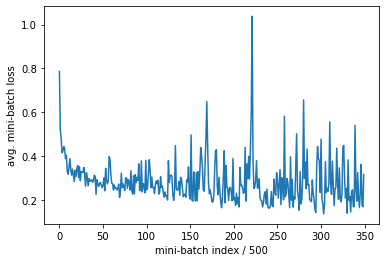

In [13]:
#training loss curve
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [14]:
# Get test accuracy.
correct = 0
total = 0

labelsForAUC = []
predictFOrAUC = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg19.forward(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        labelsForAUC.append(labels.cpu().numpy())
        predictFOrAUC.append(predicted.cpu().numpy())

print('Accuracy of the network test images: %d %%' % (
    100 * correct / total))

Accuracy of the network test images: 85 %


In [15]:
label= np.concatenate( labelsForAUC, axis=0)
predict = np.concatenate( predictFOrAUC, axis=0)

In [16]:
cMatrix = confusion_matrix(y_true=label,y_pred=predict,labels=[0, 1, 2])

Text(0.5, 0.98, 'Confusion Matrix')

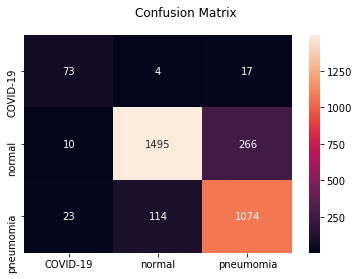

In [17]:
ax = sn.heatmap(cMatrix,annot=True,fmt="d",xticklabels=classes,yticklabels=classes)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.suptitle('Confusion Matrix')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


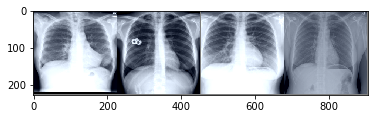

GroundTruth:  pneumomia normal normal normal
Predicted:  normal normal normal normal


In [18]:
# The function to show an image.
def imshow(img):
    img = img / 3.33 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Check several images.
dataiter = iter(test_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = vgg19.forward(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))